# E-news Express Readers' interests analysis
## Summary

Online news portal, E-news Express, is looking to expand it subscribers. To this end, they are introducing a new feature to the portal - a new landing page. The company wishes to know if this new landing page is more effective at attracting new subscribers. An A/B test has been carried out on 100 users. The users were divided equally into a control group, which viewed the old landing page, and an experimental group, which viewed the new landing page. The results are organized into a dataset with the following variables:

1. user_id - Unique ID for each user
2. group - Which experimental group the user is in
3. landing_page - Which landing page user views
4. time_spent_on_the_page - time (minutes) user viewed landing page
5. converted - whether user becomes a subscriber or not
6. language_preferred - language landing page was view in

## Purpose
Assess the results of the A/B test on the new landing page. **E-news Express wants to know if the new landing page is more effective at attracting new subscriptions.**

---
## Data Import and Cleaning

In [1]:
"""Import packages required for the analysis"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
"""Import data, format dataframe, check for null values, and check for incorrect
entries within the data"""
# Import data into a dataframe
raw_abdata = pd.read_csv('abtest.csv')
raw_df = raw_abdata.copy()

# adjust column titles for easier use
name_map = {"user_id":"id", "landing_page":"page",
           "time_spent_on_the_page":"time", "converted":"sub",
           "language_preferred":"language"}
raw_df.rename(name_map, axis=1, inplace=True)

# Check for any null values in the dataset
print("Check for null values")
print(raw_df.isnull().sum(), '\n')

# Adjust column dtypes: group, page, language are all categorical. Change sub to boolean.
ls = ['group', 'page', 'language'] 
for i in ls:
    raw_df[i] = raw_df[i].astype('category')
raw_df['sub_bool'] = raw_df['sub'].copy().map({"yes": True, "no":False})
raw_df['sub_bool'] = raw_df['sub_bool'].astype('bool')
raw_df['sub'] = raw_df['sub'].astype('category')

# Check that id are unique identifiers
if raw_df.id.value_counts().sum() == len(raw_df.id):
    print("All user id's are unique", '\n')
else:
    print("A user id is repeated")

# Check for repeated categories for group, page, and language
print("Check for repeat categories")
print(raw_df.group.unique())
print(raw_df.page.unique())
print(raw_df.language.unique(), '\n')

# Check that all control users view the old page and all treatment view the new page
r1, c1 = raw_df[(raw_df['group'] == "control") & (raw_df['page'] == "new")].shape
r2, c2 = raw_df[(raw_df['group'] == "treatment") & (raw_df['page'] == "old")].shape
if r1 != 0 or r2 !=0:
    print("""There are bad data entries. Control or treatment individuals 
    are noted to have view the wrong page""")
else:
    print("""There are no bad data entries""", "\n")

# set to new dataframe
df = raw_df
df.info()

Check for null values
id          0
group       0
page        0
time        0
sub         0
language    0
dtype: int64 

All user id's are unique 

Check for repeat categories
['control', 'treatment']
Categories (2, object): ['control', 'treatment']
['old', 'new']
Categories (2, object): ['old', 'new']
['Spanish', 'English', 'French']
Categories (3, object): ['Spanish', 'English', 'French'] 

There are no bad data entries 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        100 non-null    int64   
 1   group     100 non-null    category
 2   page      100 non-null    category
 3   time      100 non-null    float64 
 4   sub       100 non-null    category
 5   language  100 non-null    category
 6   sub_bool  100 non-null    bool    
dtypes: bool(1), category(4), float64(1), int64(1)
memory usage: 2.7 KB


For ease of use several column names have been changed:
- ***user_id*** is now ***id***
- ***landing_page*** is now ***page***
- ***time_spent_on_page*** is now ***time***
- ***converted*** is now ***sub***
- ***language_preferred*** is now ***language***

One other change was to convert the yes and no responses with regards to subscription to a boolean True and False and save it as a sepearte ***sub_bool*** column.

Overall, the data is very clean. There are no null values, no repeated user id's, none of the categorical data entries have differences in capitalization or spelling, and there are no data entry errors, such a user in the control group being noted as viewing the new page.

---
## Data Exploration
 

In [3]:
# Examine generalized descriptive statistics for dataset
df.describe(include='all')

,id,group,page,time,sub,language,sub_bool
count,100.000000,100,100,100.000000,100,100,100
unique,NaN,2,2,NaN,2,3,2
top,NaN,control,new,NaN,yes,French,True
freq,NaN,50,50,NaN,54,34,54
mean,546517.000000,NaN,NaN,5.377800,NaN,NaN,NaN
std,52.295779,NaN,NaN,2.378166,NaN,NaN,NaN
min,546443.000000,NaN,NaN,0.190000,NaN,NaN,NaN
25%,546467.750000,NaN,NaN,3.880000,NaN,NaN,NaN
50%,546492.500000,NaN,NaN,5.415000,NaN,NaN,NaN
75%,546567.250000,NaN,NaN,7.022500,NaN,NaN,NaN


#### Notes:
- ***id*** is simply a unique identifier. Implies independence of data points.
- ***group*** is split 50/50 between *control* and *treatment* as stated in description of dataset
- ***page*** is split 50/50 between *old* and *new* as stated in description of dataset, and cleaning validated no data entry errors.
- ***time*** is only qunatitiative variable in the dataset. Mean time a user spends on the page is 5.38 minutes and the median is 5.42 minutes, with a range of 0.19 to 10.71 minutes. This is likely a fairly normal distribution.
- ***sub*** suggests useres are slightly more likley to subscribe (54 out of 100) than not. However, this is with the data not yet split based on condition.
- ***language*** shows there are three different langauges requested by users: French, Spanish, and English.
- ***sub_bool*** simply a boolean colukmn of the ***sub*** column to enable easy numerical comparison where *yes* is a value of 1 and *no* is a value of 0.

In [4]:
# Examine generalized descriptive statistics for control group
df[df['group'] == 'control'].describe(include='all')

,id,group,page,time,sub,language,sub_bool
count,50.00000,50,50,50.000000,50,50,50
unique,NaN,1,1,NaN,2,3,2
top,NaN,control,old,NaN,no,French,False
freq,NaN,50,50,NaN,29,17,29
mean,546566.50000,NaN,NaN,4.532400,NaN,NaN,NaN
std,17.67767,NaN,NaN,2.581975,NaN,NaN,NaN
min,546493.00000,NaN,NaN,0.190000,NaN,NaN,NaN
25%,546555.25000,NaN,NaN,2.720000,NaN,NaN,NaN
50%,546567.50000,NaN,NaN,4.380000,NaN,NaN,NaN
75%,546579.75000,NaN,NaN,6.442500,NaN,NaN,NaN


In [5]:
# Examine generalized descriptive statistics for treatment group
df[df['group'] == 'treatment'].describe(include='all')

,id,group,page,time,sub,language,sub_bool
count,50.00000,50,50,50.000000,50,50,50
unique,NaN,1,1,NaN,2,3,2
top,NaN,treatment,new,NaN,yes,French,True
freq,NaN,50,50,NaN,33,17,33
mean,546467.50000,NaN,NaN,6.223200,NaN,NaN,NaN
std,14.57738,NaN,NaN,1.817031,NaN,NaN,NaN
min,546443.00000,NaN,NaN,1.650000,NaN,NaN,NaN
25%,546455.25000,NaN,NaN,5.175000,NaN,NaN,NaN
50%,546467.50000,NaN,NaN,6.105000,NaN,NaN,NaN
75%,546479.75000,NaN,NaN,7.160000,NaN,NaN,NaN


#### Notes:
When data is split into treatment groups most features are the same between the two, suggesting strong regulatory control on the A/B testing process. However, there are a few notable differences:
- On average, those in the ***control*** group **may have spent less time on the page** than those in the ***treatment*** group.
- **More individuals subscribed** in the ***treatment*** group than in the ***control*** group.

<AxesSubplot:xlabel='time'>

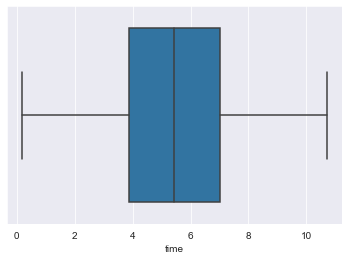

In [6]:
# Assess posibilities of outliers for time, the one quantitiative variable
sns.boxplot(data=df, x='time')

Time likely is a normal distribution (p > 0.05). Null hypothesis not rejected.


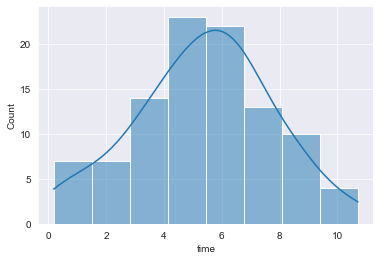

In [7]:
# Assess distribution of time variable and whether the disrtibution is normal
sns.histplot(data=df, x='time', kde=True)

k2, p = stats.normaltest(df.time) # normality test based on 2-sided chi squared analysis
alpha = 0.05
if p < alpha:
    print("Time is likely not a normal distribution (p < 0.05). Null hypothesis rejected.")
else:
    print("Time likely is a normal distribution (p > 0.05). Null hypothesis not rejected.")

#### Notes:
- There are not outliers within the overall distribution of ***time***.
- ***time*** does have a normal distribution for this dataset, therefore **statistical tests that assume normality are reasonable.**

---
### Categorical Analyses
- What proportion of each treatment group subscribed?
- Are the languages used distributed equally between the groups?
- Might language influence how many users subscribe?


In [8]:
def bar_perc(plot, feature, h=0.33, w=0.08):
    '''
    plot
    feature: 1-d categorical feature array
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.0f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - w # width of the plot
        y = p.get_y() + p.get_height() + h         # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage

Text(0, 0.5, 'Number of users')

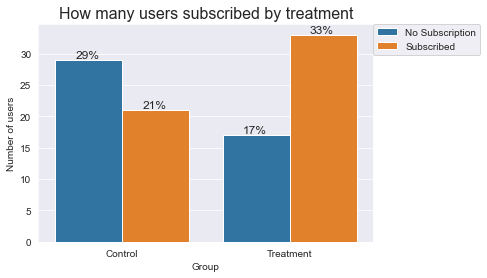

In [9]:
# What proportion of each treatment group subscribed?
ax = sns.countplot(data=df, x='group', hue='sub')
bar_perc(ax, df.time)
plt.legend(bbox_to_anchor=(1.0,1), loc='upper left', borderaxespad=0, labels=["No Subscription", "Subscribed"])
plt.title('How many users subscribed by treatment', fontdict={'fontsize':16})
plt.xlabel('Group')
plt.xticks(np.arange(0,2), labels=["Control", "Treatment"])
plt.ylabel('Number of users')

#### Notes:
**More users subscribe** under the ***new page*** than the ***old page***. *33% of the whole dataset subscribed from the treatment group*, which means **66% did so within the treatment group**. *21% of the whole dataset subscribed from the control group*, which means **42% did so within the control group**.

These percentages within the treatment groups are above and below 50% correspondingly which is suggestive a a difference, however this will need to be tested statistically.

Text(0, 0.5, 'Number of users')

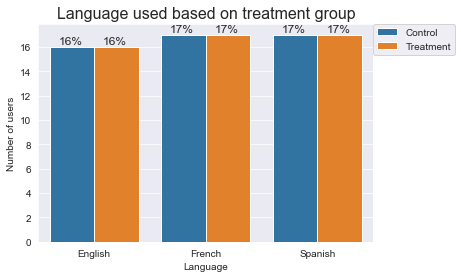

In [10]:
# Are the languages used distributed equally between the groups?
ax = sns.countplot(data=df, x='language', hue='group')
bar_perc(ax, df.language, h=0.25, w=0.12)
plt.legend(bbox_to_anchor=(1.0,1), loc='upper left', borderaxespad=0, labels=["Control", "Treatment"])
plt.title('Language used based on treatment group', fontdict={'fontsize':16})
plt.xlabel('Language')
plt.ylabel('Number of users')

#### Notes:
- **Langage is equal across control groups**. Therefore, what langauge used is cannot be a bias between the treatment groups. 
- **The percentage of language used is nearly equal across the types of language**. Therefore, it is unlikely any trends observed due to langauge are an artifact of more or fewer individuals within that treatment group using that langauge.

Text(0, 0.5, 'Number of users')

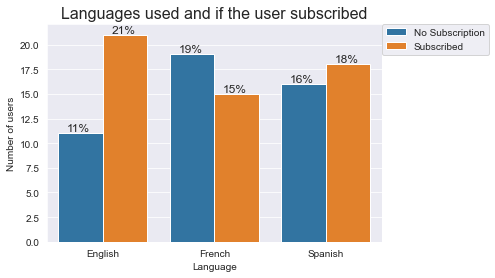

In [11]:
# Might language influence how many users subscribe?
ax = sns.countplot(data=df, x='language', hue='sub')
bar_perc(ax, df.language, h=0.2, w=0.12)
plt.legend(bbox_to_anchor=(1.0,1), loc='upper left', borderaxespad=0, labels=["No Subscription", "Subscribed"])
plt.title('Languages used and if the user subscribed', fontdict={'fontsize':16})
plt.xlabel('Language')
plt.ylabel('Number of users')

#### Notes:
- **English language users** were the ***more likely to subscribe than any other langauge***.
- **French language users** were the ***least likely to subscribe***.

It's unclear at this point if langauge influences subscription rates. The all appear relatively similar, with perhaps the exception of the English language users who may have a significantly higher subscription rate.


---
### Quantitative Analyses:
- Does time users spend on the page appear to change based on treatment group?
- Does time users spend on the page appear to influence if they subscribe?
- Does time users spend on the page appear to change based on the language they view the page in?



(0.0, 14.701975470371943)

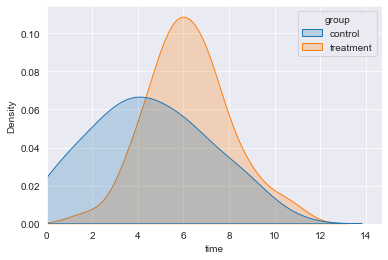

In [12]:
# Does time users spend on the page appear to change based on treatment group?
sns.kdeplot(data=df, x='time', hue='group', shade=True)
plt.xlim(0)

In [13]:
# T-test of two independent samples to examine if time is different between control and treatment groups
T, p = stats.ttest_ind(df[df['group'] == 'treatment'].time, 
                df[df['group'] == 'control'].time,
                alternative='greater')
print("T-stat =", T, '\n', "p-value =", p)


T-stat = 3.7867702694199856 
 p-value = 0.0001316123528095005


#### Notes:
As seen from the descriptive stats, the **new page** (*treatment*) does **increase the amount of time** users spend on the page. A T-test demonstrates we can be confident that this increase in time based on treatment is significant (p < 0.05).

(0.0, 13.814742305418273)

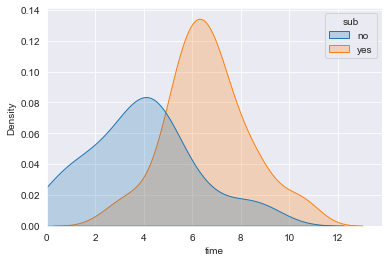

In [14]:
# Does time users spend on the page appear to influence if they subscribe?
sns.kdeplot(data=df, x='time', hue='sub', shade=True)
plt.xlim(0)

In [15]:
# T-test of two independent samples to examine if time is different between those who subscribe and those who don't
T, p = stats.ttest_ind(df[df['sub'] == 'yes'].time, 
                df[df['sub'] == 'no'].time,
                alternative='greater')
print("T-stat =", T, '\n', "p-value =", p)


T-stat = 6.871662040801039 
 p-value = 2.9536890937324255e-10


#### Notes:

As seen from the descriptive stats, the **greater the amount of time** users spend on the page **the more likely they are to have subscribed**. A T-test demonstrates we can be confident that this increase in time based on treatment is significant (p < 0.05).

<AxesSubplot:xlabel='language', ylabel='time'>

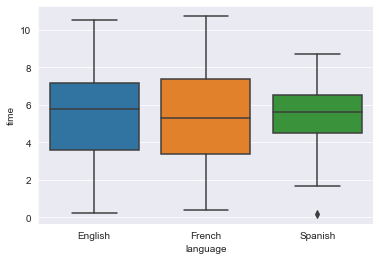

In [16]:
# Does time users spend on the page appear to change based on the language they view the page in?
sns.boxplot(data=df, x='language', y='time')

In [17]:
# One-way ANOVA to examine if time is different if a user uses a different language
F, p = stats.f_oneway(df[df['language'] == 'English'].time, 
                       df[df['language'] == 'French'].time,
                       df[df['language'] == 'Spanish'].time)
print("F-stat =", F, '\n', "p-value =", p)


F-stat = 0.14343439221240437 
 p-value = 0.8665610536012648


#### Notes:
***Language*** does not appear tho change the **amount of time** users spend on the page. Anova demonstrates the distributions are not significantly from each other (p > 0.05).

### Conclusions based on data exploration
 - **Time** is a normally distributed variable
 - **More users** from the **treatment** group **subscribed** than from the **control** group
 - **Language** is **equally distibuted** across the **groups**
 - **Language might influence** how many users **subscribe**
 - Users in the **treatment** group spend **more time** on the new page compared to users in the **control** group who view the old page
 - Users who **spend more time** on the page (*regardless of old or new*) are **more likely to subscribe**
 - The **language** with which a user views the page **does not influnce the time** that user spends on the page

---
## Analysis
### Questions:
1. Do users spend more time on the new landing page than the old landing page?
2. Is the conversion rate (proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?
3. Does the converted status depend on the preferred language?
4. Is the mean time spent on the new page same for different language users?

---
### Do users spend more time on the new landing page than the old landing page?
Inadverdantly addressed this question in exploration by checking on the effects of treatment groups, which maps perfectly onto pages. However, this analysis will directly address this in a more formal analysis.


Users viewing the new page spent an average of 6.22 minutes on the page.
Users viewing the old page spet an average of 4.53 minutes on the page.


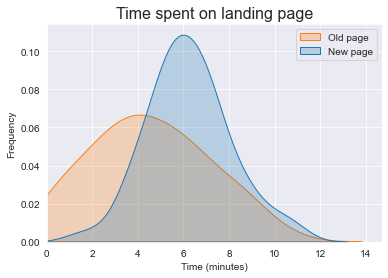

In [18]:
# Split dataframe into old and new page viewers
new = df[df['page'] == 'new']
old = df[df['page'] == 'old']

# Find average of time spent on each page
print("Users viewing the new page spent an average of", round(new['time'].mean(), 2), "minutes on the page.")
print("Users viewing the old page spet an average of", round(old['time'].mean(), 2), "minutes on the page.")

# Plot the kernal density plots for the distribution
sns.kdeplot(data=df, x='time', hue='page', shade=True)
plt.xlim(0)
plt.title("Time spent on landing page", fontdict={'fontsize':16})
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.legend(labels=["Old page", "New page"])
plt.savefig('Figures\TimeSpentonLandingPage.jpeg', dpi=300, bbox_inches='tight')

The analysis needs to address whether the distribution of time users view the new page is significantly different than the time users view the old page. Therefore, the hypotheses for the final test are:

$H_0$: $\mu \leq 4.53 \text{ minutes}$


$H_a$: $\mu > 4.53 \text{ minutes}$

As this dataset is a 100 member sample, split evenly into new and old page treatments, we do not know the standard deviation of whole population - all of E-new Express Customer Base. Hence, a T-test of two independent samples will be used to account for the lack of information on the populations standard deviation and the independence of the individuals participating in each 50 member treatment.

In [19]:
# T-test for independent samples to assess if the difference spent on the pages is significantly different
T, p = stats.ttest_ind(df[df['page'] == 'new'].time, 
                df[df['page'] == 'old'].time,
                alternative='greater')
print("T-stat =", round(T, 3), '\n', "p-value = ", round(p, 4))

T-stat = 3.787 
 p-value =  0.0001


 *The null hypothesis is rejected (p < 0.05)*. Therefore, we can be 95% confident that on average **the new landing page is viewed by users for longer than the old landing page**.

---
### Is the conversion rate (proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

Conversion rate for the new page is 0.66
Conversion rate for the old page is 0.42


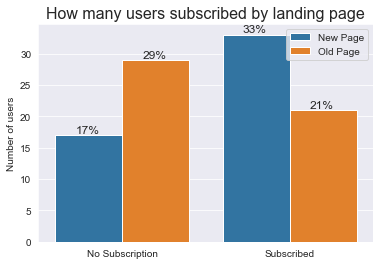

In [20]:
# Calculate conversion rates for old and new pages
n = 50 # Total number of users in both old and new samples
subrate_new = new['sub_bool'].sum()/n
subrate_old = old['sub_bool'].sum()/n
print("Conversion rate for the new page is", subrate_new)
print("Conversion rate for the old page is", subrate_old)

# What proportion of each treatment group subscribed?
ax = sns.countplot(data=df, x='sub', hue='page')
bar_perc(ax, df.time)
plt.legend(labels=["New Page", "Old Page"])
plt.title('How many users subscribed by landing page', fontdict={'fontsize':16})
plt.xlabel('')
plt.xticks(np.arange(0,2), labels=["No Subscription", "Subscribed"])
plt.ylabel('Number of users')
plt.savefig('Figures\ConversionRates.jpeg', dpi=300, bbox_inches='tight')

The conversion rate is a binomial measure, a user subscribes or they do not. Therefore, I want to test if the conversion rate of the new page is significantly above the conversion rate of the old page, 0.42.

**To test if new conversion rate is greater than 0.42 (*old conversion rate*)**

$H_0$: $\mu \leq 0.42$


$H_a$: $\mu > 0.42$

In [21]:
# Test for significance of a binomial distribution with the probability value (p) set as 0.42
p = stats.binom_test(new['sub_bool'].sum(), n=50, p=0.42, alternative='greater')
print("p-value = ", round(p, 4))

p-value =  0.0005


*The null hypothesis can be rejected (p < 0.05)*. Therefore, we can be 95% confident that **the conversion rate of the new landing page is greater than the conversion rate of the old landing page**.

---
### Does the converted status depend on the preferred language?

This question is unclear as to whether it is in regards to the whole sample (both new and old landing pages) or just one. Therefore, I will test all scenarios.

#### Converted status vs language for users viewing either landing page

$H_0$: $\text{The rate of conversion does not vary based on the langauge in which the page is viewed.}$


$H_a$: $\text{The rate of conversion does vary based on the langauge in which the page is viewed.}$

In [22]:
# Crosstab of language and whether or not a user subscribed based on complete sample
pd.crosstab(df.sub_bool, df.language)

language,English,French,Spanish
sub_bool,,,
False,11,19,16
True,21,15,18


In [23]:
# Chi-square test for indepenence of the variables on a contingency table for complete sample
obs = pd.crosstab(df.sub_bool, df.language)
chi2, p, dof, expected = stats.chi2_contingency(obs, correction=False) # Yates' correction False due to df > 1
print("Chi-squared = ", round(chi2, 3), "\n", "p-value = ", round(p, 3), "\n", "degrees of freedom =", dof)

Chi-squared =  3.093 
 p-value =  0.213 
 degrees of freedom = 2


*The null hypothesis cannot be rejected (p > 0.05)*. Therefore, we can be 95% confident that, *for the whole 100 user sample*, **the conversion rate does not significantly change based on the language the landing page is viewed in**.

#### Converted status vs language for users viewing the new landing page

$H_0$: $\text{The rate of conversion does not vary based on the langauge in which the page is viewed.}$


$H_a$: $\text{The rate of conversion does vary based on the langauge in which the page is viewed.}$

In [24]:
# Crosstab of language and whether or not a user subscribed based on new page
pd.crosstab(new.sub_bool, new.language)

language,English,French,Spanish
sub_bool,,,
False,6,5,6
True,10,12,11


In [25]:
# Chi-square test for indepenence of the variables on whether or not a user subscribed based on new page
obs = pd.crosstab(new.sub_bool, new.language)
chi2, p, dof, expected = stats.chi2_contingency(obs, correction=False) # Yates' correction False due to df > 1
print("Chi-squared = ", round(chi2, 3), "\n", "p-value = ", round(p, 3), "\n", "degrees of freedom =", dof)

Chi-squared =  0.26 
 p-value =  0.878 
 degrees of freedom = 2


*The null hypothesis cannot be rejected (p > 0.05)*. Therefore, we can be 95% confident that, *for the 50 user sample who viewed the new landing page*, **the conversion rate does not significantly change based on the language the landing page is viewed in**.

#### Converted status vs language for users viewing the old landing page

$H_0$: $\text{The rate of conversion does not vary based on the langauge in which the page is viewed.}$


$H_a$: $\text{The rate of conversion does vary based on the langauge in which the page is viewed.}$

In [26]:
# Crosstab of language and whether or not a user subscribed based on old page
pd.crosstab(old.sub_bool, old.language)

language,English,French,Spanish
sub_bool,,,
False,5,14,10
True,11,3,7


In [27]:
# Chi-square test for indepenence of the variables on whether or not a user subscribed based on old page
obs = pd.crosstab(old.sub_bool, old.language)
chi2, p, dof, expected = stats.chi2_contingency(obs, correction=False) # Yates' correction False due to df > 1
print("Chi-squared = ", round(chi2, 3), "\n", "p-value = ", round(p, 3), "\n", "degrees of freedom =", dof)

Chi-squared =  8.843 
 p-value =  0.012 
 degrees of freedom = 2


*The null hypothesis can be rejected (p > 0.05)*. Therefore, we can be 95% confident that, *for the 50 user sample who viewed the old landing page*, **the conversion rate does significantly change based on the language the landing page is viewed in**.

---
### Is the mean time spent on the new page same for different language users?

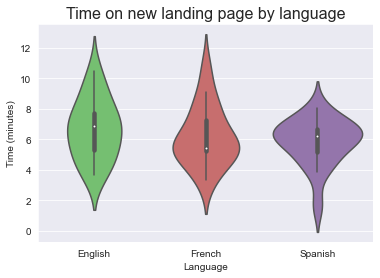

In [28]:
# Violin plot to examine the distribution of time spent on the new landing page for each language
sns_cmap = sns.color_palette('muted').as_hex()
lang_cmap = sns_cmap[2:5]
sns.violinplot(x=new['language'], y=new['time'], palette=lang_cmap)
plt.title('Time on new landing page by language', fontdict={'fontsize':16})
plt.xlabel('Language')
plt.ylabel('Time (minutes)')
plt.savefig('Figures/NewPageLangvsTimeSpent.jpeg', dpi=300, bbox_inches='tight')

This analysis will require an ANOVA test of variance to see if the means of the time spent on the new landing page by each group of language speakers are the same or different.

$H_0$: $\mu_{1} = \mu_{2} = \mu_{3}$


$H_a$: $\text{The means are not all equal}$

As shown in the data exploration, **time** is a normal distribution. Therefore an ANOVA will be an accurate test to compare the means of time on the new page based on language.

In [29]:
# One-way ANOVA to examine if time on the new page is different if a user uses a different language
F, p = stats.f_oneway(new[new['language'] == 'English'].time, 
                       new[new['language'] == 'French'].time,
                       new[new['language'] == 'Spanish'].time)
print("F-stat=", round(F, 3), '\n', "p-value = ", round(p, 3))

F-stat= 0.854 
 p-value =  0.432


*The null hypothesis cannot be rejected (p > 0.05)*. Therefore, we can be 95% confident that **the time spent on the new page does not change based on the language with which the page is being viewed**.

## Conclusions
### Questions:
1. Do users spend more time on the new landing page than the old landing page?
> *Users do spend more time on the new landing page than the old landing page.*
2. Is the conversion rate (proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?
> *Yes, the conversion rate for the new page is greater than for the old page.*
3. Does the converted status depend on the preferred language?
> *Converted status only changes based on language for the old landing page. There is no significant differenence in conversion rates based on language for users viewing the new page or for the sample of all 100 users.*
4. Is the mean time spent on the new page same for different language users?
> *No, the time spent on the new page does not vary based on the language used to view the page.*